# SAAC: Sequence-Aware Adhesin Classification

From new_spaan with 350-dimensional features, about 4k sequences rather than 24k, with a lighter model (just a 50-dim layer) and adding a piece of sequence* processed by an LSTM layer to see the performance improvement.

*it doesn't make sense because there is no a priori reason to choose just a piece of it, but if we consider the entire sequence the computational cost rises too much.

In [27]:
%%capture
!pip install Biopython
!rm -r iFeature
!rm -r spaan
!git clone https://github.com/Superzchen/iFeature
!git clone https://github.com/nicolagulmini/spaan

import numpy as np
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from Bio import SeqIO

np.random.seed(42)

In [28]:
def from_files_to_vectors(fasta_path, positive=True):
    if positive:
        proteins = list(SeqIO.parse(fasta_path+'adhesins.fasta', "fasta"))
    else:
        proteins = list(SeqIO.parse(fasta_path+'non_adhesins.fasta', "fasta"))
    extension = ".out"
    files = ["aac", "dpc", "ctdc", "ctdt", "ctdd"]
    if positive:
        names = "_cleaned_pos"
    else:
        names = "_cleaned_neg"
    for i in range(len(files)):
        files[i] += names
    datasets = [[] for el in files]
    for i in range(len(files)):
        with open(fasta_path+files[i]+extension) as f:
            lines = f.readlines()[1:]
            check_prot = 0
            for line in lines:
                information = line.split('\t')
                if not information[0] == proteins[check_prot].id:
                    print("Error in protein order! Return")
                    return datasets
                datasets[i].append(np.array([float(el) for el in information[1:]]))
                check_prot += 1
        datasets[i] = np.array(datasets[i])
    return datasets

In [29]:
# put the right path
pos_datasets = from_files_to_vectors("./spaan/new_data/", positive=True)
neg_datasets = from_files_to_vectors("./spaan/new_data/", positive=False)

In [30]:
# sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

positive = list(SeqIO.parse("./spaan/new_data/adhesins.fasta", "fasta"))
negative = list(SeqIO.parse("./spaan/new_data/non_adhesins.fasta", "fasta"))
MAXLEN = 500 #max([len(el.seq) for el in positive+negative])
    
aa_list = [
    'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X', 'B', 'U'
    ]

# PAY ATTENTION!! MANY SEQUENCES HAVE 'X' AS AN AMINOACID. WE NEED TO REMOVE THEM FROM THE DATASETS. THERE IS ALSO A 'B' AND A 'U' I CANNOT FIND OUT

def seq_to_ind(seq):
    ind_seq = []
    for aa in seq:
        ind_seq.append(aa_list.index(aa)+1)
    return pad_sequences([ind_seq], maxlen=MAXLEN, padding='post', truncating='post')[0]

X_seq = np.array([seq_to_ind(el.seq) for el in positive+negative])

In [31]:
y_pos = np.ones(pos_datasets[0].shape[0])
y_neg = np.zeros(neg_datasets[0].shape[0])

In [32]:
# attach datasets in order to obtain a matrix of (n, 20+400+39+39+195) features

# keep in mind the number of adhesins and the number of not adhesins
rows = 0
n_pos = y_pos.shape[0]
n_neg = y_neg.shape[0]
rows = n_pos + n_neg
print('Adhesins:', n_pos)
print('NON Adhesins:', n_neg)

# feature vectors dimensions
columns = 0
for i in range(len(pos_datasets)):
    tmp_dim = pos_datasets[i].shape[1]
    print(i+1, '-th feature dim:', tmp_dim)
    columns += tmp_dim

# data matrix to process
X = np.zeros((rows, columns))
print('Data matrix dimension:', X.shape)
for i in range(n_pos):
    X[i] = np.concatenate([pos_datasets[j][i] for j in range(5)])
for i in range(n_neg):
    X[n_pos+i] = np.concatenate([neg_datasets[j][i] for j in range(5)])

Adhesins: 12066
NON Adhesins: 11259
1 -th feature dim: 20
2 -th feature dim: 400
3 -th feature dim: 39
4 -th feature dim: 39
5 -th feature dim: 195
Data matrix dimension: (23325, 693)


In [33]:
# permutation
y = np.concatenate((y_pos, y_neg), axis=0)
c = np.random.permutation(np.arange(y.shape[0]))
y = y[c]
X = X[c] 
X_seq = X_seq[c]

In [34]:
# since after the training we realized that about 2000 data points are sufficient, we try to reduce the dataset dimension
MAX_N_SEQ = 4000
X = X[:MAX_N_SEQ]
X_seq = X_seq[:MAX_N_SEQ]
y = y[:MAX_N_SEQ]

In [35]:
# remember: standardization or scaling AFTER train-test split, otherwise there's data leakage!!!
X_train = X[:int(X.shape[0]*.5)]
X_seq_train = X_seq[:int(X_seq.shape[0]*.5)]
X_val = X[int(X.shape[0]*.5):int(X.shape[0]*.75)]
X_seq_val = X_seq[int(X_seq.shape[0]*.5):int(X_seq.shape[0]*.75)]
X_test = X[int(X.shape[0]*.75):]
X_seq_test = X_seq[int(X_seq.shape[0]*.75):]

y_train = y[:int(y.shape[0]*.5)]
y_val = y[int(y.shape[0]*.5):int(y.shape[0]*.75)]
y_test = y[int(y.shape[0]*.75):]

print('Training data shape:', X_train.shape, y_train.shape)
print('Validation data shape:', X_val.shape, y_val.shape)
print('Test data shape:', X_test.shape, y_test.shape)

print('\nTraining adhesins and not-adhesins:', int(sum(y_train)), int(y_train.shape[0]-sum(y_train)))
print('Validation adhesins and not-adhesins:', int(sum(y_val)), int(y_val.shape[0]-sum(y_val)))
print('Test adhesins and not-adhesins:', int(sum(y_test)), int(y_test.shape[0]-sum(y_test)))

Training data shape: (2000, 693) (2000,)
Validation data shape: (1000, 693) (1000,)
Test data shape: (1000, 693) (1000,)

Training adhesins and not-adhesins: 1048 952
Validation adhesins and not-adhesins: 509 491
Test adhesins and not-adhesins: 507 493


## PCA

In [36]:
# standardize data

# print some column vectors to check
print('Before standardization:')
print('mean of the first column:', np.mean(X_train[:,0]))
print('mean of the second column:', np.mean(X_train[:,1]))
print('mean of the 451-th column:', np.mean(X_train[:,450]))

stdX = np.zeros(X_train.shape)
for j in range(X_train.shape[1]):
    column = X_train[:,j]
    stdX[:,j] = (column - np.mean(column)) / np.std(column)

print('After standardization:')
print('mean of the first column:', np.mean(stdX[:,0]))
print('mean of the second column:', np.mean(stdX[:,1]))
print('mean of the 451-th column:', np.mean(stdX[:,450]))

Before standardization:
mean of the first column: 0.08655038184713132
mean of the second column: 0.009596437560088943
mean of the 451-th column: 0.10121304629062956
After standardization:
mean of the first column: 6.750155989720952e-17
mean of the second column: 9.947598300641403e-17
mean of the 451-th column: -1.0658141036401503e-17


In [37]:
covariance_matrix = np.cov(stdX.T)

In [38]:
# The covariance matrix is symmetric, and thus has real eigenvalues. You may see a small imaginary part in some eigenvalues due to numerical error. The imaginary parts can generally be ignored.
# source: https://stackoverflow.com/questions/10420648/complex-eigen-values-in-pca-calculation

eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
eigen_values = np.real(eigen_values)
eigen_vectors = np.real(eigen_vectors)

In [39]:
# Calculating the explained variance on each of components

variance_explained = []
for i in eigen_values:
    variance_explained.append((i/sum(eigen_values))*100)

print(variance_explained)

[7.6408269067954935, 5.429831335996434, 4.053223206875548, 3.6117514575634453, 2.8313559902164642, 2.7490305254478407, 2.348333225568392, 1.8905255092800672, 1.4730282452711654, 1.4035663708926363, 1.1138889926641233, 1.0633979525311688, 0.9925140043478954, 0.922942724215417, 0.9091601342396104, 0.8824029467105458, 0.7810118766915957, 0.7114991661463506, 0.6864718141232515, 0.6632612988044285, 0.6358379037723582, 0.5932961891280596, 0.5809886773798244, 0.5750549397068887, 0.5566182472551497, 0.5525423040667576, 0.51540753210597, 0.4973312634399591, 0.47608508384893, 0.4698675552022665, 0.46245680644562503, 0.4474864474480334, 0.4458057216714403, 0.43109535375006164, 0.42849713612620083, 0.41247632976509446, 0.39467663577621326, 0.3841983453078483, 0.37313094028927435, 0.3704062904164522, 0.36157806164339207, 0.3574968877617845, 0.349617850100962, 0.3406348009314314, 0.336325124392261, 0.3311454459060608, 0.3292396659082453, 0.3137694541478766, 0.31115222743808, 0.3070388094971694, 0.30

In [40]:
cumulative_variance_explained = np.cumsum(variance_explained)

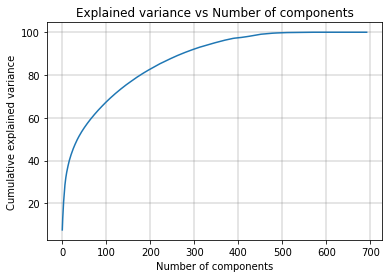

In [41]:
plt.title("Explained variance vs Number of components")

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(color='gray', linewidth=.4)

plt.plot(range(len(cumulative_variance_explained)), cumulative_variance_explained)
plt.savefig('Explained variance.png')

In [42]:
K = 350
print('Principal components:', K)
print('Discarded components:', columns-K)

Principal components: 350
Discarded components: 343


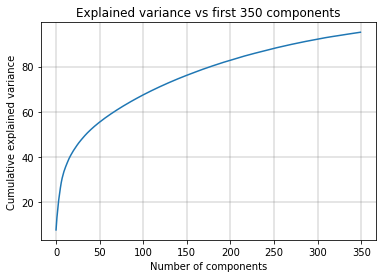

In [43]:
plt.title("Explained variance vs first " + str(K) + " components")

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(color='gray', linewidth=.4)

plt.plot(range(K), cumulative_variance_explained[:K])

plt.show()
#plt.savefig('Explained variance.png')

In [44]:
# Project using first K components

projection_matrix = np.real((eigen_vectors.T[:][:K]).T)
print(projection_matrix.shape)

(693, 350)


In [45]:
# standardize validation and test data and then project

stdX_val = np.zeros(X_val.shape)
for j in range(X_val.shape[1]):
    column = X_val[:,j]
    stdX_val[:,j] = (column - np.mean(column)) / np.std(column)

stdX_test = np.zeros(X_test.shape)
for j in range(X_test.shape[1]):
    column = X_test[:,j]
    stdX_test[:,j] = (column - np.mean(column)) / np.std(column)

# project matrices
X_train = stdX.dot(projection_matrix)
X_val = stdX_val.dot(projection_matrix)
X_test = stdX_test.dot(projection_matrix)

## Neural Network

In [46]:
class neural_network:
    def __init__(self):
        input = tensorflow.keras.Input(shape=(K,))
        input_sequence = tensorflow.keras.Input(shape=(MAXLEN))

        embed = tensorflow.keras.layers.Embedding(24, 32)(input_sequence) # cause we have 23 aminoacids
        LSTM_layer = tensorflow.keras.layers.LSTM(32, dropout=.1)(embed)
        LSTM_final_dense = tensorflow.keras.layers.Dense(1, activation='sigmoid')(LSTM_layer)
        
        dense = tensorflow.keras.layers.Dense(50, activation='sigmoid')(input)
        norm = tensorflow.keras.layers.BatchNormalization()(dense)
        drop = tensorflow.keras.layers.Dropout(.5)(norm)
        #dense = tensorflow.keras.layers.Dense(50, activation='sigmoid')(drop)
        output = tensorflow.keras.layers.Dense(1, activation='sigmoid')(drop)

        concat = tensorflow.keras.layers.Concatenate()([output, LSTM_final_dense])
        final_output = tensorflow.keras.layers.Dense(1, activation='sigmoid')(concat)

        model = tensorflow.keras.models.Model(inputs=[input, input_sequence], outputs=final_output)
        model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics='accuracy')
        self.model = model

In [47]:
nn = neural_network()

In [ ]:
history = nn.model.fit(
    x=[X_train, X_seq_train], 
    y=y_train,
    batch_size=64,
    epochs=400,
    verbose=1,
    validation_data=([X_val, X_seq_val], y_val),
    #shuffle=True,
    callbacks=[tensorflow.keras.callbacks.EarlyStopping(
    restore_best_weights=True,
    patience=10
        )]
)

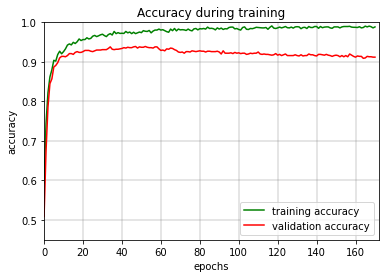

In [49]:
plt.title('Accuracy during training')
plt.plot(range(len(history.history['loss'])), history.history['accuracy'], label='training accuracy', color='green')
plt.plot(range(len(history.history['loss'])), history.history['val_accuracy'], label='validation accuracy', color='red')
plt.grid(color='gray', linewidth=.4)

plt.legend(loc="lower right")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0, len(history.history['loss'])+1)
plt.ylim(.45, 1.)
plt.savefig('acc.png')

In [52]:
nn.model.evaluate(x=[X_test, X_seq_test], y=y_test)

32/32 [==============================] - 1s 24ms/step - loss: 0.2671 - accuracy: 0.9210


[0.26705607771873474, 0.9210000038146973]

In [53]:
nn.model.save('new_spaan_model.h5')